## HW1: Futures Spread Dynamics

My last two distinct digits of my student id are 8 and 7. 
Therefore i will be studying NYM.RB versus ICE.G × 0.0033 and CBT.TU versus CBT.US × 0.7894

NYM.RB is reformulated gasoline futures from NY mercantile exchange (mostly represents prices in the US)

ICE.G is brent gasoil futures from ICE (represents prices in europe and globally)

CBT.TU represents 2-years US treasury note futures (traded on chicago board of trade)

CBT.US represents 30-years US treasury note futures (traded on chicago board of trade)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import os
import datetime
# import plotnine as p9

API_key = 'CazLxm9XJ7CzL3g8prJm'
quandl.ApiConfig.api_key = API_key



c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r"C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS" , "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=API_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )


## Download all data from implied vol models values

In [3]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)


Data file C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS\quandl_data_table_downloads\AR/IVM_20250113.zip size 323695782 exists already, no need to download


In [32]:
print(t_ivm.head())

  exchange_code futures_code option_code expiration        date    futures  \
0           CBT           BO          BO         1M  2024-12-16  41.731864   
1           CBT           BO          BO         1W  2024-12-16  41.589492   
2           CBT           BO          BO         1Y  2024-12-16  42.360909   
3           CBT           BO          BO         2M  2024-12-16  41.915763   
4           CBT           BO          BO         3M  2024-12-16  42.079836   

        atm      rr25      rr10     fly25  ...     beta1      beta2     beta3  \
0  0.302640  0.017717  0.028022  0.008861  ...  0.136273   2.253584 -4.503889   
1  0.275612 -0.009755 -0.026915  0.008703  ... -0.184783  12.724505 -9.970579   
2  0.280757  0.027657  0.056929  0.003687  ...  0.080256  -0.029207 -0.342699   
3  0.329431  0.043624  0.072584  0.009547  ...  0.234473   0.732446 -3.166721   
4  0.331620  0.046527  0.078083  0.009520  ...  0.207442   0.439917 -1.951898   

        beta4       beta5        beta6  min_

We have daily data of several products with different days_termination. We are interested in gathering second month future prices of products

## Get the data we are interested in

7. CBT.TU versus CBT.US × 0.7894
8. NYM.RB versus ICE.G × 0.0033

for future we use days_termination (and not days_expiration which is for options)

In [4]:
start_date = '2021-12-03'
end_date = '2024-08-31'
condition_date = (t_ivm['date'] >= start_date) & (t_ivm['date'] <= end_date)
filtered_data = t_ivm[condition_date]

def get_second_month_expiry(data):
    if 'days_termination' not in data.columns:
        raise ValueError('days_termination not in data')
    data = data[data['days_termination'] > 30].sort_values(by = 'days_termination').groupby('date').first().reset_index()
    
    return data
data_cbt_tu = get_second_month_expiry(filtered_data[(filtered_data['exchange_code'] == 'CBT') & (filtered_data['futures_code'] == 'TU')])
data_cbt_us = get_second_month_expiry(filtered_data[(filtered_data['exchange_code'] == 'CBT') & (filtered_data['futures_code'] == 'US')])
data_nym_rb = get_second_month_expiry(filtered_data[(filtered_data['exchange_code'] == 'NYM') & (filtered_data['futures_code'] == 'RB')])
data_ice_g = get_second_month_expiry(filtered_data[(filtered_data['exchange_code'] == 'ICE') & (filtered_data['futures_code'] == 'G')])

## Compute speads with corresponding multipliers


In [5]:
spread_df_7 = pd.merge(data_cbt_tu, data_cbt_us, on = 'date', suffixes = ('_TU', '_US'))
spread_df_7['spread'] = spread_df_7['futures_US']*0.7894 - spread_df_7['futures_TU']
spread_df_7 = spread_df_7[['date','spread']]

spread_df_8 = pd.merge(data_nym_rb, data_ice_g, on = 'date', suffixes = ('_RB', '_G'))
spread_df_8['spread'] = spread_df_8['futures_G']*0.0033 - spread_df_8['futures_RB']
spread_df_8 = spread_df_8[['date','spread']]


## Analyse spread7 and spread8 series


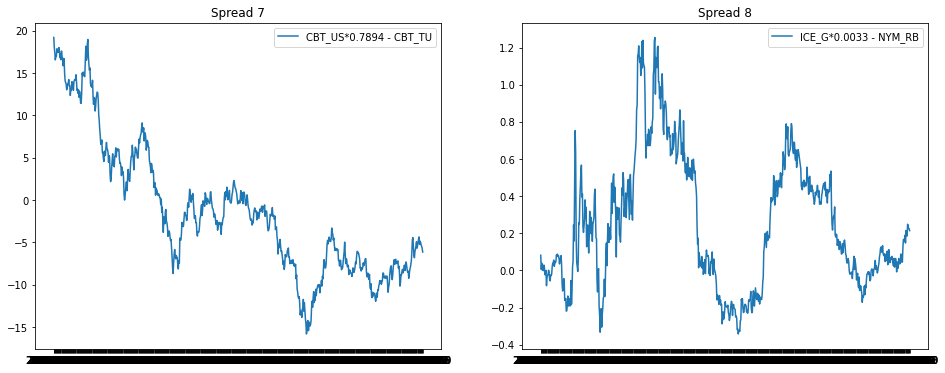

In [48]:
fig, ax = plt.subplots(1,2, figsize = (16,6))

ax[0].plot(spread_df_7['date'], spread_df_7['spread'], label = 'CBT_US*0.7894 - CBT_TU')
ax[0].legend()
ax[0].set_title('Spread 7')

ax[1].plot(spread_df_8['date'], spread_df_8['spread'], label = 'ICE_G*0.0033 - NYM_RB')
ax[1].legend()
ax[1].set_title('Spread 8')

plt.show()



We can see a spread 7 a clear down trend

Spread 8 exhibits a mean reverting pattern

We could create trading strategies to profit from those patterns (shorting spread 7 and mean revert spread 8)

In [23]:
## print statistics of spreads
print("Statistics of spread7:", "\n", spread_df_7['spread'].describe(), "\n")
print("Statistics of spread8:", "\n", spread_df_8['spread'].describe())

Statistics of spread7: 
 count    715.000000
mean      -1.300875
std        7.893412
min      -15.825837
25%       -7.509797
50%       -2.358372
75%        2.950496
max       19.200946
Name: spread, dtype: float64 

Statistics of spread8: 
 count    709.000000
mean       0.246261
std        0.350570
min       -0.342450
25%       -0.010236
50%        0.162299
75%        0.483175
max        1.254567
Name: spread, dtype: float64


## Checking return distribution of spreads

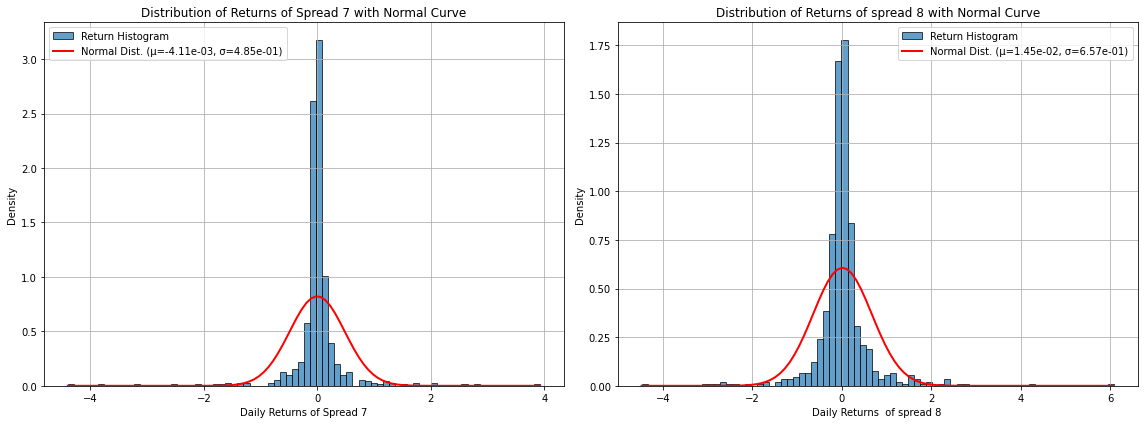

In [47]:
from scipy.stats import norm

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

returns7 = np.log(spread_df_7['spread'] / spread_df_7['spread'].shift(1)).dropna()
mu, std = norm.fit(returns7)

num_bins = 3*int(np.sqrt(len(returns7)))
axes[0].hist(returns7, bins=num_bins, density=True, alpha=0.7, edgecolor='k', label='Return Histogram')

# Plot the normal distribution curve
x = np.linspace(returns7.min(), returns7.max(), 100)
axes[0].plot(x, norm.pdf(x, mu, std), 'r', linewidth=2, label=f'Normal Dist. (µ={mu:.2e}, σ={std:.2e})')

axes[0].set_title('Distribution of Returns of Spread 7 with Normal Curve')
axes[0].set_xlabel('Daily Returns of Spread 7')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)


returns8 = np.log(spread_df_8['spread'] / spread_df_8['spread'].shift(1)).dropna()
mu, std = norm.fit(returns8)

axes[1].hist(returns8, bins=num_bins, density=True, alpha=0.7, edgecolor='k', label='Return Histogram')

# Plot the normal distribution curve
x = np.linspace(returns8.min(), returns8.max(), 100)
axes[1].plot(x, norm.pdf(x, mu, std), 'r', linewidth=2, label=f'Normal Dist. (µ={mu:.2e}, σ={std:.2e})')

axes[1].set_title('Distribution of Returns of spread 8 with Normal Curve')
axes[1].set_xlabel('Daily Returns  of spread 8 ')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

We can see the log return distribution of spread 7 and spread 8 have an empirical normal distribution shape.
We could assume assume normality of distribution with those fitted parameters to run linear regression for example, or to model prices with stochastic differential equation.

## Auto-correlation of spread and spread return time series


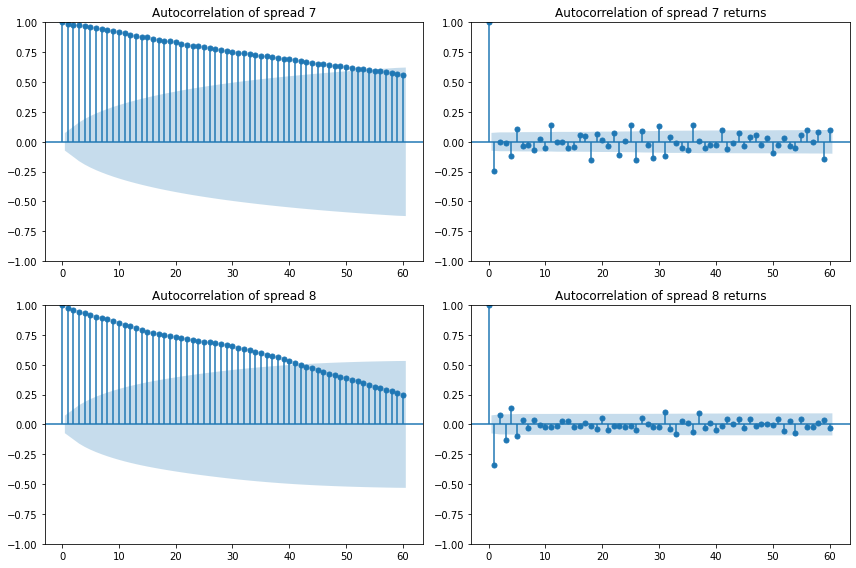

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(spread_df_7['spread'], lags=60, ax=axes[0,0], title="Autocorrelation of spread 7")
plot_acf(returns7, lags=60, ax=axes[0,1], title="Autocorrelation of spread 7 returns")

plot_acf(spread_df_8['spread'], lags=60,  ax=axes[1,0], title="Autocorrelation of spread 8")
plot_acf(returns8, lags=60,  ax=axes[1,1], title="Autocorrelation of spread 8 returns")

plt.tight_layout()
plt.show()

The analysis of auto-correlation helps understanding whether the dynamic is stationnary or not, if there is mean reversion or a trend in the process.

Each graph have bars that represent the correlation of the studied time series with its lagged version (lags going from 0 to 60). It also have a shaded area that shows the 'statistical significiance' of the auto-correlation (not statistically significant if the bar inside the shaded area).

A low auto-correlation indicates mean reversion whereas a high auto-correlation indicates trend

We can see a slow decay of autocorrelation for spread 7 and spread 8 as the lag increases that indicate non stationnarity of the process with a trend. The auto-correlation decay in spread 8 is stronger and the auto-correlation  becomes insignifiante after 30 days, which implies mean reversion of the process

For the returns, we get very low auto-correlation as expected (since can be modelled with a random walk)

## Analyse the d(t) = s(t) - rolling_avg(N)

D(t) is called the detrented serie, it removes the local trend from the serie to leave only the fluctuation

For small N: the rolling avg represents short term trends and therefore d(t) will reprensents long term dynamics (since you remove the short dynamic)

For large N: the rolling avg represents long term trends and therefore d(t) will reprensents short term dynamics (since you remove the long dynamic)


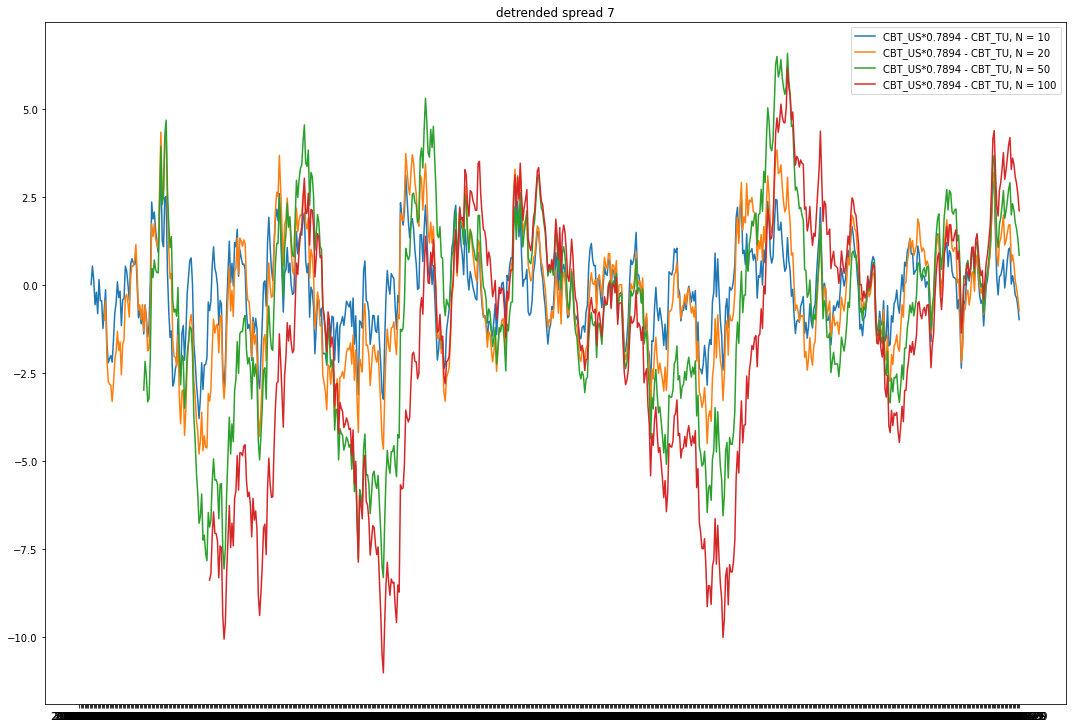

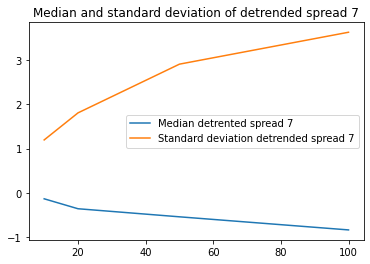

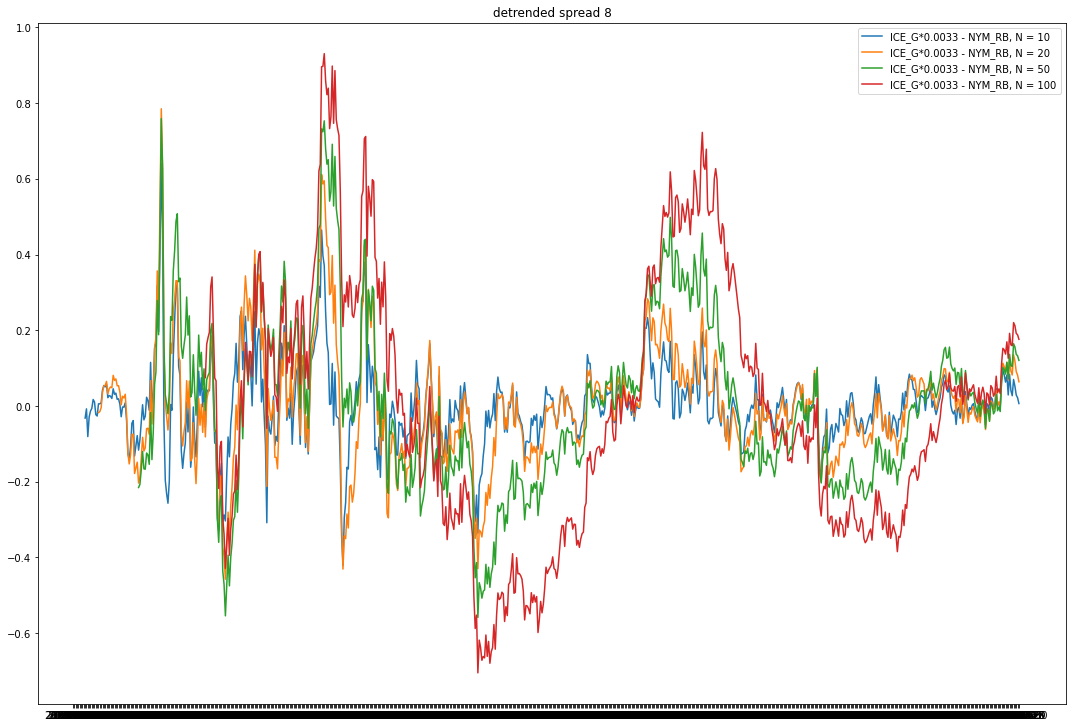

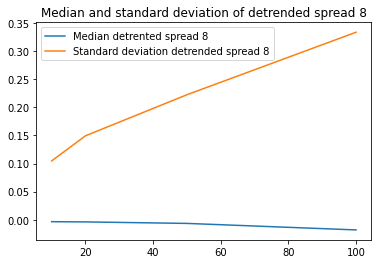

In [28]:
N_values = [10,20,50,100]
plt.figure(figsize=(15,10))
median_list_7 = []
std_list_7 = []
for n in N_values:
    spread_df_7['rolling_mean_'+str(n)] = spread_df_7['spread'] - (spread_df_7['spread'].rolling(window = n)).mean() 
    median_list_7.append(spread_df_7['rolling_mean_'+str(n)].median())
    std_list_7.append(spread_df_7['rolling_mean_'+str(n)].std())
    # print('rolling_mean_'+str(n),spread_df_7['rolling_mean_'+str(n)].describe())
    plt.plot(spread_df_7['date'], spread_df_7['rolling_mean_'+str(n)], label = 'CBT_US*0.7894 - CBT_TU, N = '+str(n))

plt.tight_layout()
plt.title('detrended spread 7')
plt.legend()
plt.show()

plt.plot(N_values, median_list_7, label = 'Median detrented spread 7')
plt.plot(N_values, std_list_7, label = 'Standard deviation detrended spread 7')  
plt.legend()
plt.title('Median and standard deviation of detrended spread 7')
plt.show()

plt.figure(figsize=(15,10))
median_list_8 = []
std_list_8 = []
for n in N_values:
    spread_df_8['rolling_mean_'+str(n)] = spread_df_8['spread'] - (spread_df_8['spread'].rolling(window = n)).mean()
    median_list_8.append(spread_df_8['rolling_mean_'+str(n)].median())
    std_list_8.append(spread_df_8['rolling_mean_'+str(n)].std())
    # print(spread_df_7['rolling_mean_'+str(n)].describe())
    plt.plot(spread_df_8['date'], spread_df_8['rolling_mean_'+str(n)], label = 'ICE_G*0.0033 - NYM_RB, N = '+str(n))
    
plt.legend()
plt.tight_layout()
plt.title('detrended spread 8')
plt.show()

plt.plot(N_values, median_list_8, label = 'Median detrented spread 8')
plt.plot(N_values, std_list_8, label = 'Standard deviation detrended spread 8')  
plt.legend()
plt.title('Median and standard deviation of detrended spread 8')
plt.show()



The standard deviation evolution w.r.t N shows that the larger N is, the higher is the std (proving we capture short deviation)

In a trading strategy, we could use this $d_{N}(t)$ for different N to capture long term fluctuation or short term fluctuation

## Seasonality and patterns in spread?

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition7 = seasonal_decompose(spread_df_7['spread'], model='additive', period=30) 

# Extract components
trend7 = decomposition7.trend
seasonal7 = decomposition7.seasonal
residual7 = decomposition7.resid

decomposition8 = seasonal_decompose(spread_df_8['spread'], model='additive', period=30)

# Extract components
trend8 = decomposition8.trend
seasonal8 = decomposition8.seasonal
residual8 = decomposition8.resid

as we have daily data we choose to get a period of month

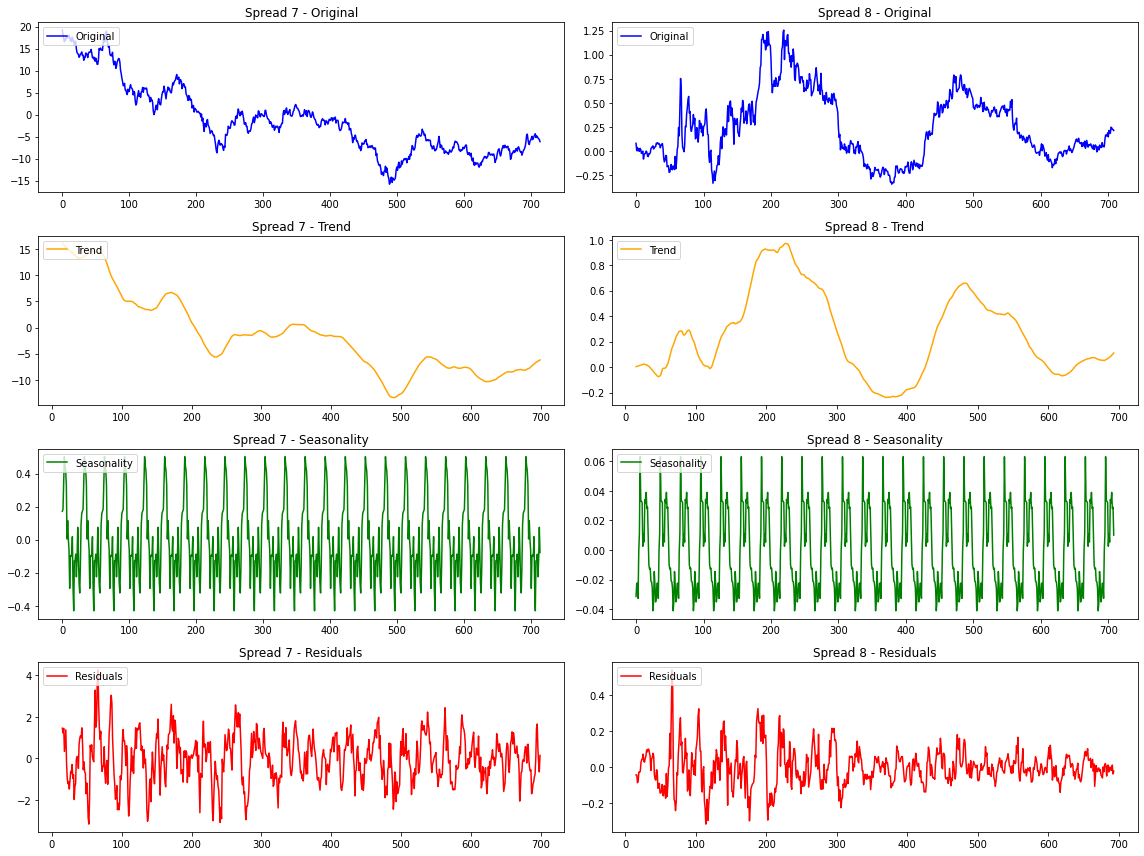

In [51]:
# Plot the decomposition results for spread7 and spread8
fig, ax = plt.subplots(4, 2, figsize=(16, 12))  # 4x2 layout

# Spread 7 Plots
ax[0, 0].plot(spread_df_7['spread'], label='Original', color='blue')
ax[0, 0].legend(loc='upper left')
ax[0, 0].set_title("Spread 7 - Original")

ax[1, 0].plot(trend7, label='Trend', color='orange')
ax[1, 0].legend(loc='upper left')
ax[1, 0].set_title("Spread 7 - Trend")

ax[2, 0].plot(seasonal7, label='Seasonality', color='green')
ax[2, 0].legend(loc='upper left')
ax[2, 0].set_title("Spread 7 - Seasonality")

ax[3, 0].plot(residual7, label='Residuals', color='red')
ax[3, 0].legend(loc='upper left')
ax[3, 0].set_title("Spread 7 - Residuals")

# Spread 8 Plots
ax[0, 1].plot(spread_df_8['spread'], label='Original', color='blue')
ax[0, 1].legend(loc='upper left')
ax[0, 1].set_title("Spread 8 - Original")

ax[1, 1].plot(trend8, label='Trend', color='orange')
ax[1, 1].legend(loc='upper left')
ax[1, 1].set_title("Spread 8 - Trend")

ax[2, 1].plot(seasonal8, label='Seasonality', color='green')
ax[2, 1].legend(loc='upper left')
ax[2, 1].set_title("Spread 8 - Seasonality")

ax[3, 1].plot(residual8, label='Residuals', color='red')
ax[3, 1].legend(loc='upper left')
ax[3, 1].set_title("Spread 8 - Residuals")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



By doing this time series decomposition we can extract a trend and a seasonality term from the time series. This could allow to analyse the trend individually for example, which can be used as a key component in a trading strategy

## Correlation between spreads?

In [15]:
col = ['date','spread_7', 'spread_8']
corr_df = spread_df_7.merge(spread_df_8, on = 'date', how='inner', suffixes = ('_7', '_8'))[col]
corr = np.corrcoef(corr_df['spread_7'], corr_df['spread_8'])[0,1]
print('the correlation between spread 7 and spread 8 is: ',corr)


the correlation between spread 7 and spread 8 is:  -0.18112224945472333


The two spread time series have a weak correlation. This makes sense since one spread is on US treasury bonds and the other is on oil. 
We could use this weak correlation for diversification in a trading strategy